In [1]:
import numpy as np
import matplotlib.pyplot as plt
from my_functions import *
import seaborn as sns
import pandas as pd

In [2]:
w_central = central_wavelength()
nb_fwhm_Arr = nb_fwhm(range(60))

In [5]:
## Load everything
filename = 'Source_cats/LAE_0.01deg_z2-5/'

mock = pd.read_csv(filename + 'data.csv')

pm_flx = mock.to_numpy()[:, :60].T

In [4]:
EW_lya = mock['EW_Arr']

zspec = mock['redshift_Lya_Arr']

In [5]:
w_lya = 1215.67 # A
N_sources = pm_flx.shape[1]
N_sources

5239

In [6]:
mag = flux_to_mag(pm_flx, w_central.reshape(-1, 1))
mag[np.isnan(mag)] = 99.

/home/alberto/cosmos/LAEs/my_functions.py:17: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f * w**2/c * 1e-8) - 48.60


In [7]:
# Lya search
cont_est_lya, cont_err_lya = estimate_continuum(pm_flx, pm_err)

# Other lines
cont_est_other, cont_err_other = estimate_continuum(pm_flx, pm_err, IGM_T_correct=False)

In [8]:
ew0lya_min = 0
ew0lya_max = 70
ew0lya_step = 8
ew0oth_min = 0
ew0oth_max = 400
ew0oth_step = 11

other_select_list = []
for ew0min in np.linspace(ew0oth_min, ew0oth_max, ew0oth_step):
    print(ew0min)
    line_other = is_there_line(pm_flx, pm_err, cont_est_other, cont_err_other, ew0min,
        obs=True)
    other_lines = identify_lines(line_other, pm_flx, pm_err, first=False)

    other_select_list.append(other_lines)

lya_select_list = []
lya_z_nb = []
for ew0min in np.linspace(ew0lya_min, ew0lya_max, ew0lya_step):
    print(ew0min)
    line = is_there_line(pm_flx, pm_err, cont_est_lya, cont_err_lya, ew0min)
    lya_lines, lya_cont_lines = identify_lines(line, pm_flx, pm_err, first=True)
    z_nb_Arr = np.ones(N_sources) * -1 
    z_nb_Arr[np.where(np.array(lya_lines) != -1)] =\
        z_NB(np.array(lya_cont_lines)[np.where(np.array(lya_lines) != -1)])
    
    lya_select_list.append(lya_lines)
    lya_z_nb.append(z_nb_Arr)

0.0
40.0
80.0
120.0
160.0
200.0
240.0
280.0
320.0
360.0
400.0
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0


In [27]:
mag_cut_min = 20
mag_cut_max = 25

z_cut_min = 2.14
z_cut_max = 2.22

mag_cut = (mag[-2] > mag_cut_min) & (mag[-2] < mag_cut_max)

select_grid = np.zeros((ew0lya_step, ew0oth_step))
rightz_grid = np.zeros((ew0lya_step, ew0oth_step))

target_z = (zspec > z_cut_min) & (zspec < z_cut_max)
target = (
    mag_cut & target_z & (EW_lya / (1 + zspec) > 20)
)

for i in range(ew0lya_step):
    print(i)
    for j in range(ew0oth_step):
        line_len_Arr = np.array([len(l) for l in other_select_list[j]])
        nice_lya = (np.array(lya_select_list[i]) != -1) & (line_len_Arr <= 1)
        nice_z = np.abs(lya_z_nb[i] - zspec) < 0.12
        
        z_nb_cut = (lya_z_nb[i] > z_cut_min) & (lya_z_nb[i] < z_cut_max)

        selected = mag_cut & nice_lya & z_nb_cut
        select_grid[i, j] = len(np.where(selected)[0])
        rightz_grid[i, j] = len(np.where(selected & nice_z)[0])

N_target = len(np.where(target)[0])
purity = rightz_grid / select_grid
completeness = rightz_grid / N_target

0
1
2
3
4
5
6
7


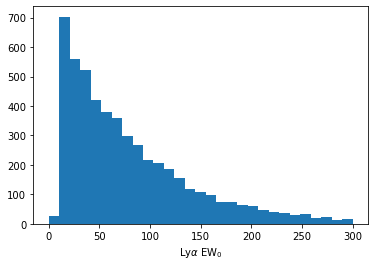

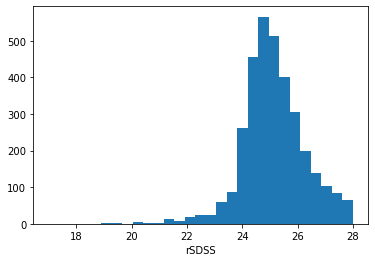

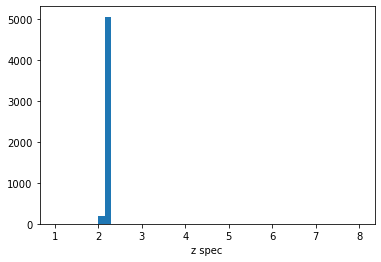

In [28]:
plt.hist(EW_lya, bins=np.linspace(0, 300, 30))
ew_x = np.linspace(0, 200, 10000)
ew_dist = np.exp(-ew_x / 75)
ew_norm = simpson(ew_dist, ew_x)
#plt.plot(ew_x, ew_dist / ew_norm)
plt.xlabel(r'Ly$\alpha$ EW$_0$')
plt.show()

plt.hist(mag[-3], bins=np.linspace(17, 28, 30))
plt.xlabel('rSDSS')
plt.show()

plt.hist(zspec, bins=np.linspace(1, 8, 50))
plt.xlabel('z spec')
plt.show()

In [30]:
np.where(selected)

(array([ 299,  381,  488, 2230, 5109]),)

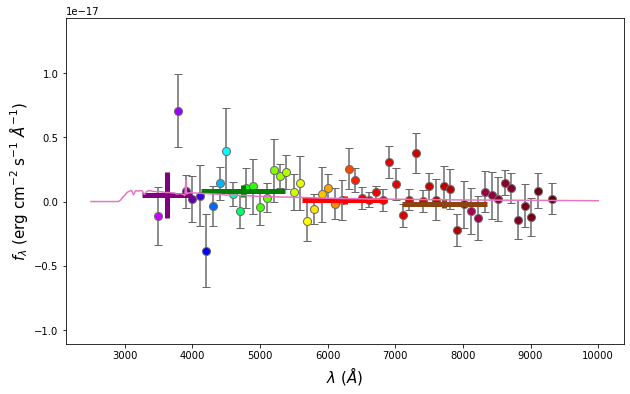

rSDSS = 25.95


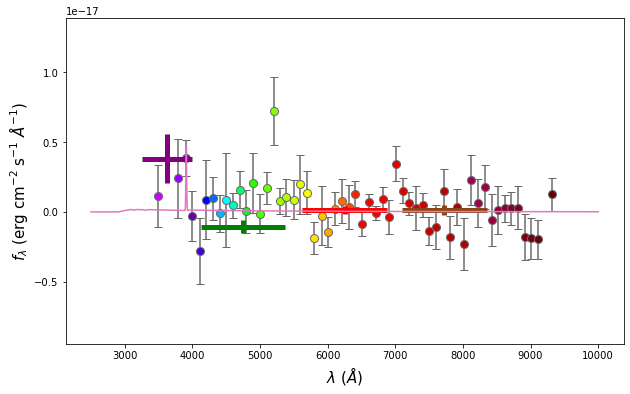

rSDSS = 25.89


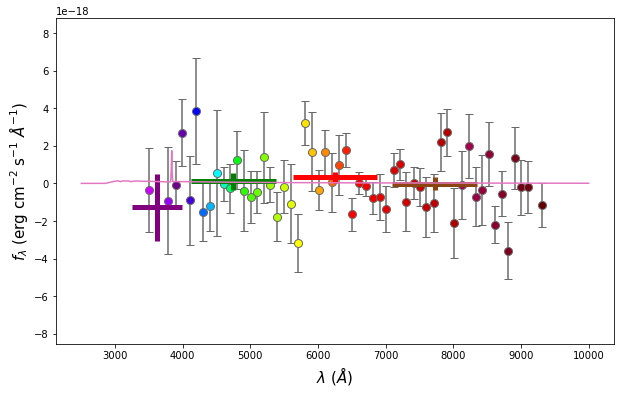

rSDSS = 24.80


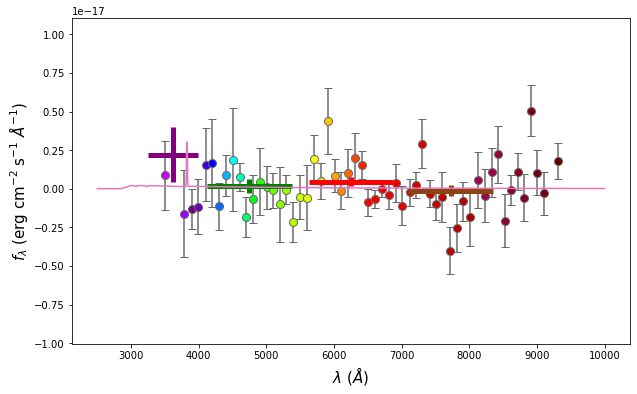

rSDSS = 24.45


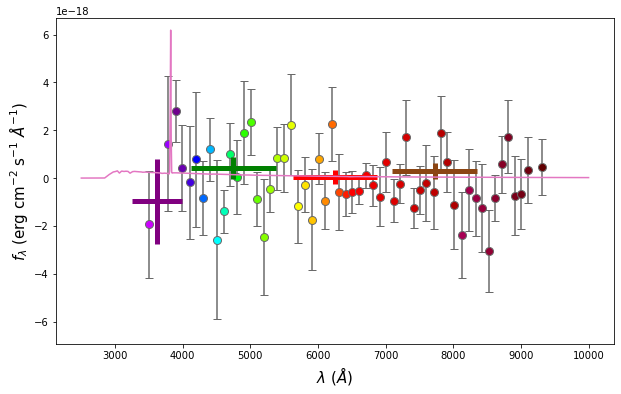

rSDSS = 27.22


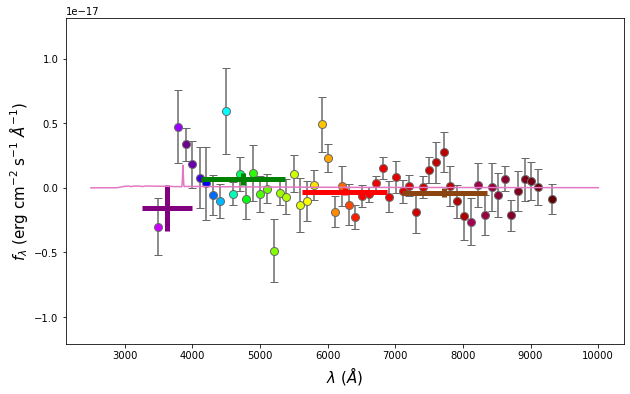

rSDSS = 99.00


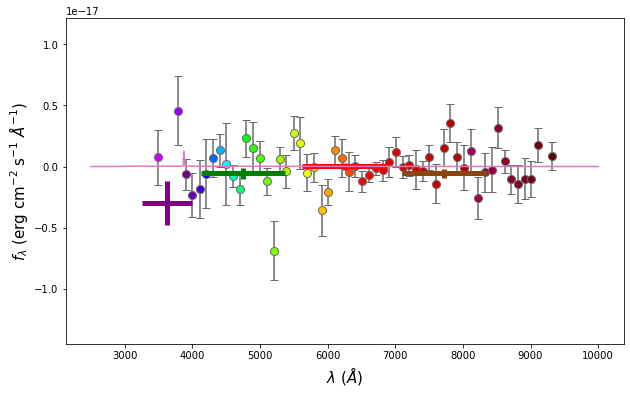

rSDSS = 28.34


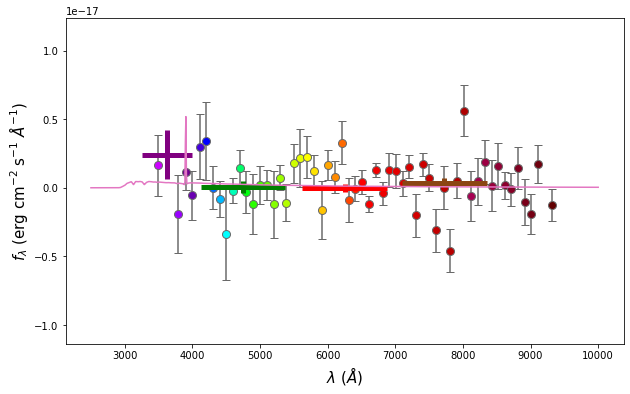

rSDSS = 29.00


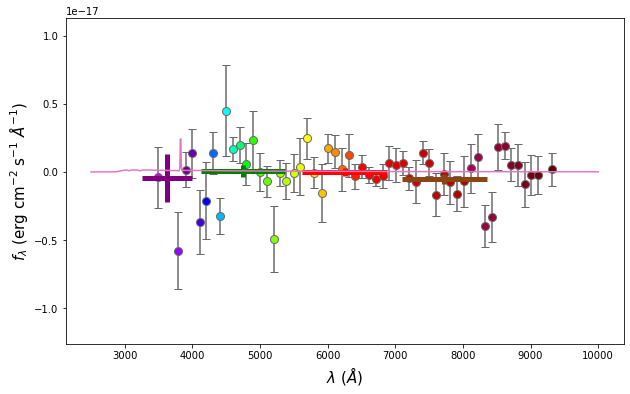

rSDSS = 99.00


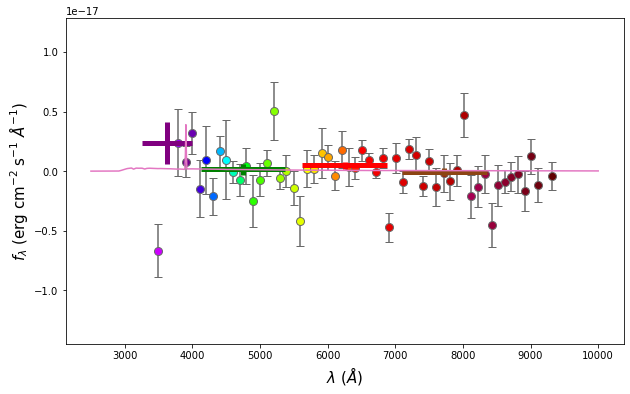

rSDSS = 24.37


In [32]:
for src in np.random.randint(0, N_sources, 10):
    fig = plt.figure(figsize=(10, 6))
    ax = plot_JPAS_source(pm_flx[:, src], pm_err[:, src])
    ax.plot(mock['w_Arr'], mock['SEDs'][src])
    plt.show()
    print('rSDSS = {0:0.2f}'.format(mag[-2, src]))

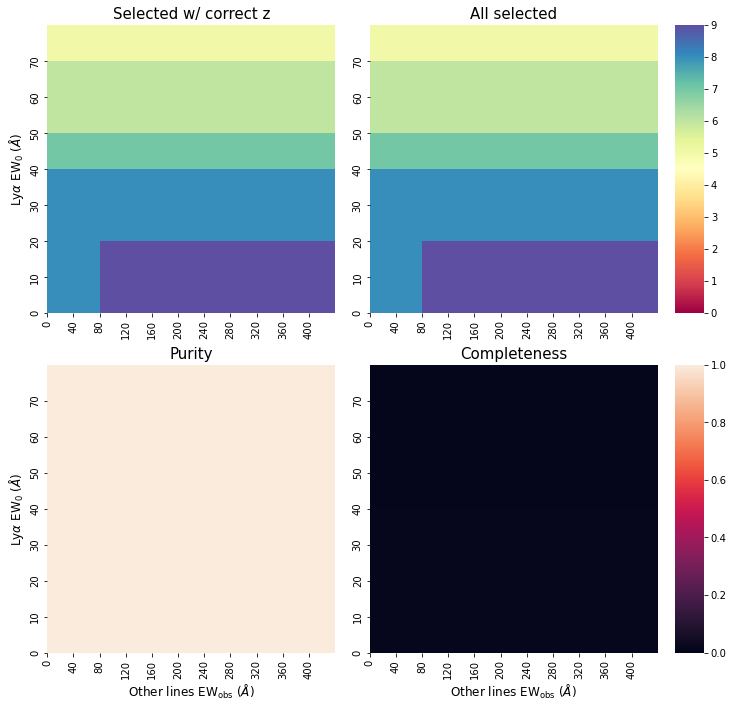

N_target = 635


In [29]:
fig = plt.figure(figsize=(8, 8))

width = 0.5
height = 0.5
spacing = 0.06
cbar_width = 0.05

# Define axes
ax00 = fig.add_axes([0, height + 1.5 * spacing, width, height])
ax01 = fig.add_axes([width + spacing, height + 1.5 * spacing, width, height], sharey=ax00)
ax10 = fig.add_axes([0, 0, width, height], sharex=ax00)
ax11 = fig.add_axes([width + spacing, 0, width, height], sharex=ax01, sharey=ax10)
axcbar0 = fig.add_axes([2 * width + 1.5 * spacing, height + 1.5 * spacing, cbar_width, height])
axcbar1 = fig.add_axes([2 * width + 1.5 * spacing, 0, cbar_width, height])

# Plot stuff in the rectangles
vmax = np.max([np.max(rightz_grid), np.max(select_grid)])
cmap = 'Spectral'

sns.heatmap(rightz_grid, ax=ax00, vmin=0, vmax=vmax, cbar_ax=axcbar0, cmap=cmap)
sns.heatmap(select_grid, ax=ax01, vmin=0, vmax=vmax, cbar_ax=axcbar0, cmap=cmap)

sns.heatmap(purity, ax=ax10, vmin=0, vmax=1, cbar_ax=axcbar1)
sns.heatmap(completeness, ax=ax11, vmin=0, vmax=1, cbar=False)

ax00.invert_yaxis()
ax10.invert_yaxis()

# Axes ticks
xticks = range(ew0oth_step)
yticks = range(ew0lya_step)
xtick_labels = ['{0:0.0f}'.format(n) for n in np.linspace(ew0oth_min, ew0oth_max, ew0oth_step)]
ytick_labels = ['{0:0.0f}'.format(n) for n in np.linspace(ew0lya_min, ew0lya_max, ew0lya_step)]

ax00.set_yticks(yticks)
ax00.set_yticklabels(ytick_labels)
ax00.set_xticks(xticks)
ax00.set_xticklabels(xtick_labels, rotation='vertical')

ax10.set_yticks(yticks)
ax10.set_yticklabels(ytick_labels)
ax10.set_xticks(xticks)
ax10.set_xticklabels(xtick_labels, rotation='vertical')

ax11.set_xticks(xticks)
ax11.set_xticklabels(xtick_labels, rotation='vertical')
ax11.set_yticks(yticks)
ax11.set_yticklabels(ytick_labels)

ax01.set_xticks(xticks)
ax01.set_xticklabels(xtick_labels, rotation='vertical')
ax01.set_yticks(yticks)
ax01.set_yticklabels(ytick_labels)

# Axes labels
ylabel = r'Ly$\alpha$ EW$_0$ ($\AA$)'
xlabel = 'Other lines EW$_\mathrm{obs}$ ($\AA$)'
ax00.set_ylabel(ylabel, fontsize=12)
ax10.set_ylabel(ylabel, fontsize=12)
ax10.set_xlabel(xlabel, fontsize=12)
ax11.set_xlabel(xlabel, fontsize=12)

# Set titles
ax00.set_title('Selected w/ correct z', fontsize=15)
ax01.set_title('All selected', fontsize=15)
ax10.set_title('Purity', fontsize=15)
ax11.set_title('Completeness', fontsize=15)

plt.savefig('output/puri-comp_magcut-' + str(mag_cut) + '.pdf', dpi=600,
    bbox_inches='tight')
plt.show()

print('N_target = {}'.format(N_target))

/home/alberto/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/alberto/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


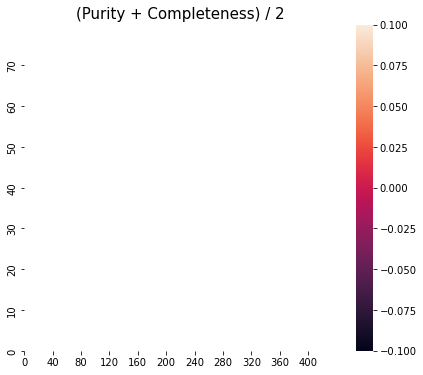

In [13]:
fig, ax = plt.subplots(figsize=(7, 6))

combined = (completeness + purity) / 2

sns.heatmap(combined, ax=ax)

xticks = range(ew0oth_step)
yticks = range(ew0lya_step)
xtick_labels = ['{0:0.0f}'.format(n) for n in np.linspace(ew0oth_min, ew0oth_max, ew0oth_step)]
ytick_labels = ['{0:0.0f}'.format(n) for n in np.linspace(ew0lya_min, ew0lya_max, ew0lya_step)]

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(xtick_labels)
ax.set_yticklabels(ytick_labels)

ax.invert_yaxis()

ax.set_title(r'(Purity + Completeness) / 2', fontsize=15)

plt.savefig('output/puri_plus_comp_magcut-' + str(mag_cut) + '.pdf', dpi=600,
    bbox_inches='tight')
plt.show()

In [14]:
max_combined = np.unravel_index(np.argmax(combined), rightz_grid.shape)
print(purity[max_combined])
print(completeness[max_combined])
print(max_combined)

nan
nan
(0, 0)
